# Gumbel Softmax VAE

This notebook is intended for loading and exploring arbitrary pre-trained models

In [1]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'gsvae'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'


TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32

TEMPERATURE = 1


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222 * 24 * 24
hidden_dim = 128
latent_dims = 32
classes_dim = len(dataset._label_keys)  # 92


In [9]:
model = M.gumbel.GSVAE(
    input_dim, hidden_dim, latent_dims, classes_dim, TEMPERATURE
)
criterion = M.gumbel.Loss()

train_losses, test_losses = M.gumbel.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS,
)

M.save(SAVE_NAME, model, train_losses, test_losses)

# model, train_losses, test_losses = M.load(SAVE_NAME, device)

INFO | model: pallets.models.gumbel.GSVAE
INFO | criterion: pallets.models.gumbel.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1418777.250000
INFO | epoch 1 ( 35%) loss: 259083.521765
INFO | epoch 1 ( 70%) loss: 135991.394458
INFO | epoch 1 (100%) loss: 100175.826082
INFO | epoch 1 (test) loss: 11014.241844
INFO | epoch 2 (  0%) loss: 11085.201172
INFO | epoch 2 ( 35%) loss: 11335.235168
INFO | epoch 2 ( 70%) loss: 11315.260047
INFO | epoch 2 (100%) loss: 11243.708569
INFO | epoch 2 (test) loss: 10860.804543
INFO | epoch 3 (  0%) loss: 11295.286133
INFO | epoch 3 ( 35%) loss: 11169.466787
INFO | epoch 3 ( 70%) loss: 11190.697819
INFO | epoch 3 (100%) loss: 11161.614564
INFO | epoch 3 (test) loss: 10827.099236
INFO | epoch 4 (  0%) loss: 11502.915039
INFO | epoch 4 ( 35%) loss: 11257.838887
INFO | epoch 4 ( 70%) loss: 11149.786167
INFO | epoch 4 (100%) loss: 11095.192729
INFO | epoch 4 (test) loss: 10807.785820
INFO | epoch 5 (  0%) loss: 11109.417969
INFO

# Results

torch.Size([1, 127872])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


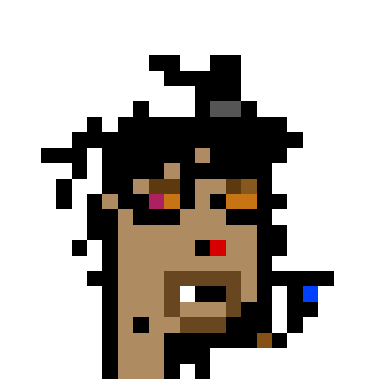

In [10]:

# Totally Random

# z = torch.randn(1, latent_dims + classes_dim).to(device)
z = torch.randn(1, latent_dims*classes_dim).to(device)


with torch.no_grad():
    model.eval()
    generated_image = model.decoder(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0].view(222, 24, 24)
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


In [11]:
# _, test_labels = next(iter(train_loader))
# features = test_labels[2]

# enabled_features = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
# print(f"Features: {enabled_features}")


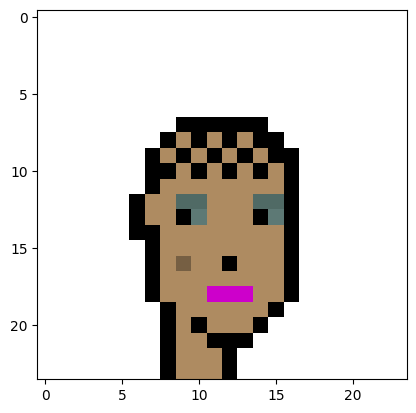

In [12]:
punk, punk_labels = dataset[1800]
punk = DS.one_hot_to_rgba(punk, dataset.mapper)

plt.imshow(to_pil_image(punk))
plt.show()



torch.Size([1, 222, 24, 24])


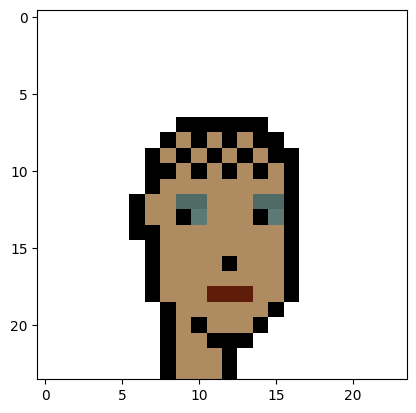

In [14]:
punk, punk_labels = dataset[1800]

p = punk.unsqueeze(0)
p = p.to(device)

model.eval()
with torch.no_grad():
    reconstructed, mu = model.forward(p)
    print(reconstructed.shape)

recon_punk = reconstructed[0].cpu()
recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)
plt.imshow(to_pil_image(recon_punk.cpu()))
plt.show()


## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

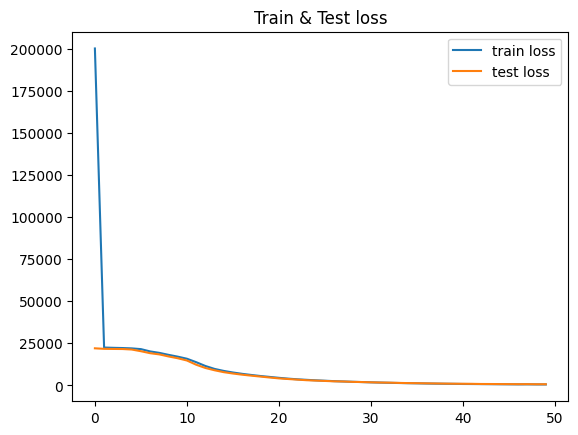

In [15]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [16]:
train_losses

[200351.65216367465,
 22487.41713763298,
 22323.229128573803,
 22190.385458222518,
 21990.227888824247,
 21552.793810255986,
 20186.5036828873,
 19328.448380707003,
 18150.58318961935,
 17072.01614098515,
 15832.546181536736,
 13799.160586526208,
 11538.053807901153,
 9784.442360303081,
 8592.028101278534,
 7653.905315859098,
 6851.514477452488,
 6172.443822982464,
 5553.733802741301,
 5012.269384073027,
 4474.657369627174,
 3998.020690485095,
 3596.7521879588458,
 3285.294523631427,
 2988.862010117118,
 2752.086898479056,
 2504.642976368573,
 2305.6131714083626,
 2129.561970162899,
 1964.418900185443,
 1793.8500504730441,
 1653.548381399601,
 1518.0362869154476,
 1405.0707790293593,
 1293.5527499043349,
 1205.657119318103,
 1096.6844697776417,
 1016.6623437759724,
 947.5690582491827,
 900.7212618564038,
 820.1189929880994,
 790.3599326492201,
 745.4907767113219,
 701.6655586188566,
 656.496327718099,
 612.1271581987962,
 570.6460688705986,
 594.8530629475912,
 542.9483346330359,
 523.

In [17]:
test_losses

[22028.483688354492,
 21721.609085083008,
 21654.198471069336,
 21615.57164001465,
 21317.45083618164,
 20311.13832092285,
 19133.294479370117,
 18416.186111450195,
 17194.072143554688,
 16131.306205749512,
 14787.022872924805,
 12289.04094696045,
 10349.468276977539,
 8983.65510559082,
 7851.44637298584,
 7043.316287994385,
 6356.130889892578,
 5769.436069488525,
 5221.467010498047,
 4668.691007614136,
 4148.904357910156,
 3773.2870693206787,
 3415.6294326782227,
 3062.904275894165,
 2841.2879314422607,
 2628.308569908142,
 2404.293140411377,
 2302.9926948547363,
 2073.488832473755,
 1968.8218460083008,
 1813.8073282241821,
 1672.4563608169556,
 1605.0490493774414,
 1456.0115718841553,
 1349.8449411392212,
 1287.4187545776367,
 1202.217978477478,
 1122.6994199752808,
 1043.0862822532654,
 974.0400147438049,
 938.2184915542603,
 899.3130605220795,
 810.6958889961243,
 792.2348489761353,
 756.9550738334656,
 729.9694738388062,
 695.8566045761108,
 714.1343593597412,
 654.5056486129761,
